# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = ????  / CV = 
- modelos:

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.calibration import CalibratedClassifierCV

from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


In [5]:
df = train.append(test)

In [6]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  114
Number of Categorical features:  19


# Feature Engineering

In [7]:
# Remove colunas com alta correlacao entre si ou com mais de 95% com zeros
#df = df.drop(columns = ['v12','v128','v13','v25','v32','v33','v34','v38','v41','v43','v46',
#                           'v49','v53','v54','v55','v60','v63','v64','v65','v67','v73','v76','v77',
#                           'v8','v83','v87','v89','v95','v96','v97'], axis = 1)

In [8]:
# Transformando as features categorias com LabelEncoder
le = LabelEncoder()

for i, col in enumerate(df):
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))

In [9]:
scaler = StandardScaler()
for c in df.columns:
    col_type = df[c].dtype
    #if col_type == 'float64' and c != 'target':
    if c != 'ID' and c != 'target':
        df[c] = scaler.fit_transform(df[c].values.reshape(-1, 1))

In [10]:
# Realizando tratamento de missing value
for c in df.columns:
    if c != 'ID' and c != 'target':
        df[c].fillna(df[c].median(),inplace=True)

In [11]:
# Add decomposed components: PCA / ICA etc.
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_df = tsvd.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_df = pca.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_df = ica.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_df = grp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_df = srp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

In [12]:
# Append decomposition components to datasets
for i in range(1, n_comp+1):
    df['pca_' + str(i)]  = pca2_results_df[:,i-1]
    df['ica_' + str(i)]  = ica2_results_df[:,i-1]
    df['tsvd_' + str(i)] = tsvd_results_df[:,i-1]
    df['grp_' + str(i)]  = grp_results_df[:,i-1]
    df['srp_' + str(i)]  = srp_results_df[:,i-1] 

In [13]:
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)
poly_features = df[['v62', 'v119', 'v123', 'v48', 'v85']]

# imputer for handling missing values
imputer = SimpleImputer(strategy = 'median')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (228714, 56)


In [14]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['v62', 'v119', 'v123', 'v48', 'v85']))

poly_features = poly_features.drop(columns = ['1'], axis = 1)

poly_features.index = df.index
df.shape, poly_features.shape

((228714, 193), (228714, 55))

In [15]:
# Merge polynomial features into training dataframe
poly_features['ID'] = df['ID']
new_df = df.merge(poly_features, on = 'ID', how = 'left')

In [16]:
print(new_df.shape)
new_df.head()

(228714, 248)


,ID,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119_x,v12,v120,v121,v122,v123_x,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48_x,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62_x,v63,v64,v65,v66,v67,v68,v69,...,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12,v62_y,v119_y,v123_y,v48_y,v85_y,v62^2,v62 v119,v62 v123,v62 v48,v62 v85,v119^2,v119 v123,v119 v48,v119 v85,v123^2,v123 v48,v123 v85,v48^2,v48 v85,v85^2,v62^3,v62^2 v119,v62^2 v123,v62^2 v48,v62^2 v85,v62 v119^2,v62 v119 v123,v62 v119 v48,v62 v119 v85,v62 v123^2,v62 v123 v48,v62 v123 v85,v62 v48^2,v62 v48 v85,v62 v85^2,v119^3,v119^2 v123,v119^2 v48,v119^2 v85,v119 v123^2,v119 v123 v48,v119 v123 v85,v119 v48^2,v119 v48 v85,v119 v85^2,v123^3,v123^2 v48,v123^2 v85,v123 v48^2,v123 v48 v85,v123 v85^2,v48^3,v48^2 v85,v48 v85^2,v85^3
0,3,1.0,-0.272688,-0.988228,1.071308,0.650933,-0.074123,-0.750536,-1.204303,-0.479126,0.270231,1.182075,0.254955,-0.066452,1.252606,0.831485,-1.969710,0.883153,0.844842,0.787983,-4.050426,-0.506524,-0.470995,-1.222867,-0.747690,-0.860540,-0.316803,-1.425299,0.656397,-0.600569,-0.421304,-0.971775,0.261331,-0.076986,-0.004848,-0.447656,-0.792381,-1.019741,0.986146,-0.318835,-0.991890,2.040279,-0.081798,-1.144070,-0.451169,0.432629,0.947942,0.653599,1.407234,-0.273492,-0.947545,-0.528972,-0.278892,0.785220,-1.677191,0.523683,-0.134466,-1.310776,-0.468331,-0.954659,-1.168345,0.426462,0.189850,-0.865791,-0.535955,-0.15536,1.163668,-0.193398,-0.868666,0.467604,-0.221216,-0.309053,-0.138143,0.344093,-0.525524,-0.926604,-0.169861,0.075643,-0.404085,-0.519778,0.031078,0.127292,1.299683,-0.527208,-0.313184,0.564731,-0.157510,-1.048515,0.148549,0.274879,-0.231802,0.603384,-0.044084,-0.518305,0.011002,1.306966,1.676532,0.022367,-1.006445,4.049148,...,0.112051,-0.002403,0.104996,-4.982273,1.826808,0.384082,-1.925611e-03,0.394732,-1.309291,-2.383022,0.706463,0.001507,0.613460,-1.423669,1.121539,-1.177009,0.000360,-1.215617,2.104040,0.319406,-0.330315,0.001974,-0.349595,2.646866,-2.272656,0.995237,0.001351,0.919744,-2.196292,-0.002955,0.508014,0.000863,-0.417986,3.865399,-5.492231,0.465660,-0.000453,0.377347,3.076456,1.289634,-2.045385,0.000979,-1.793002,-5.326863,3.765487,-0.044084,-0.747690,-0.600569,-0.169861,-0.783912,0.001943,0.032961,0.026475,0.007488,0.034558,0.559040,0.449040,0.127004,0.586123,0.360683,0.102014,0.470794,0.028853,0.133156,0.614518,-0.000086,-0.001453,-0.001167,-0.000330,-0.001523,-0.024644,-0.019795,-0.005599,-0.025838,-0.015900,-0.004497,-0.020754,-0.001272,-0.005870,-0.027090,-0.417989,-0.335742,-0.094959,-0.438239,-0.269679,-0.076275,-0.352008,-0.021573,-0.099560,-0.459469,-0.216615,-0.061266,-0.282744,-0.017328,-0.079970,-0.369061,-0.004901,-0.022618,-0.104383,-0.481729
1,4,1.0,-0.152739,-0.408217,0.343954,-0.102485,-0.235151,-0.140532,-0.150268,0.186929,0.102292,-0.944226,-0.356590,0.018854,0.058962,-0.980198,-0.175037,1.895383,-0.837254,-1.248627,-0.035365,-0.099858,0.634481,-0.112593,-0.403692,-0.403661,-0.200081,-0.222618,-0.040170,-0.313198,-0.155797,-1.562332,-0.116022,-0.167562,-0.066830,-0.447656,-0.175687,-0.290378,-0.132612,-0.318835,-0.124409,0.005355,-0.142857,-0.103772,-0.145650,-0.151665,0.228873,-0.254272,-0.285476,-0.273492,-0.947545,0.458340,-0.091518,-0.081771,-0.019800,0.071444,-0.134466,-1.310776,-0.468331,-0.118370,-0.221288,-1.376429,-0.040449,0.514313,-0.185341,-0.15536,-0.364871,0.053680,1.210403,0.021788,0.008272,-0.099063,-0.006124,0.006590,0.281461,-0.215868,-0.059996,0.007975,0.220285,-0.108701,-0.026100,0.127292,0.074515,-0.054427,-0.225903,0.

# Feature Selection

In [17]:
treino = new_df[new_df['target'].notnull()]
teste = new_df[new_df['target'].isnull()]

In [18]:
# Importância do Atributo com o Random Forest Regressor
X_ = treino.drop(['ID','target'], axis=1)
y_ = treino['target']

# Criação do Modelo - Feature Selection
modeloRF = RandomForestClassifier(bootstrap=False, 
                                 max_features=0.3, 
                                 min_samples_leaf=15, 
                                 min_samples_split=8, 
                                 n_estimators=50, 
                                 n_jobs=-1, 
                                 random_state=42)
modeloRF.fit(X_, y_)

# Convertendo o resultado em um dataframe
feature_importance_df = pd.DataFrame(treino.drop(['ID','target'], axis=1).columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloRF.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = feature_importance_df.sort_values('importance',ascending=False)
print(result)

    Feature  importance
77      v50    0.155509
94      v66    0.041079
157   ica_6    0.022472
160   srp_6    0.019234
73      v47    0.016609
..      ...         ...
100     v71    0.000285
104     v75    0.000144
54       v3    0.000130
103     v74    0.000083
196   v62^2    0.000047

[246 rows x 2 columns]


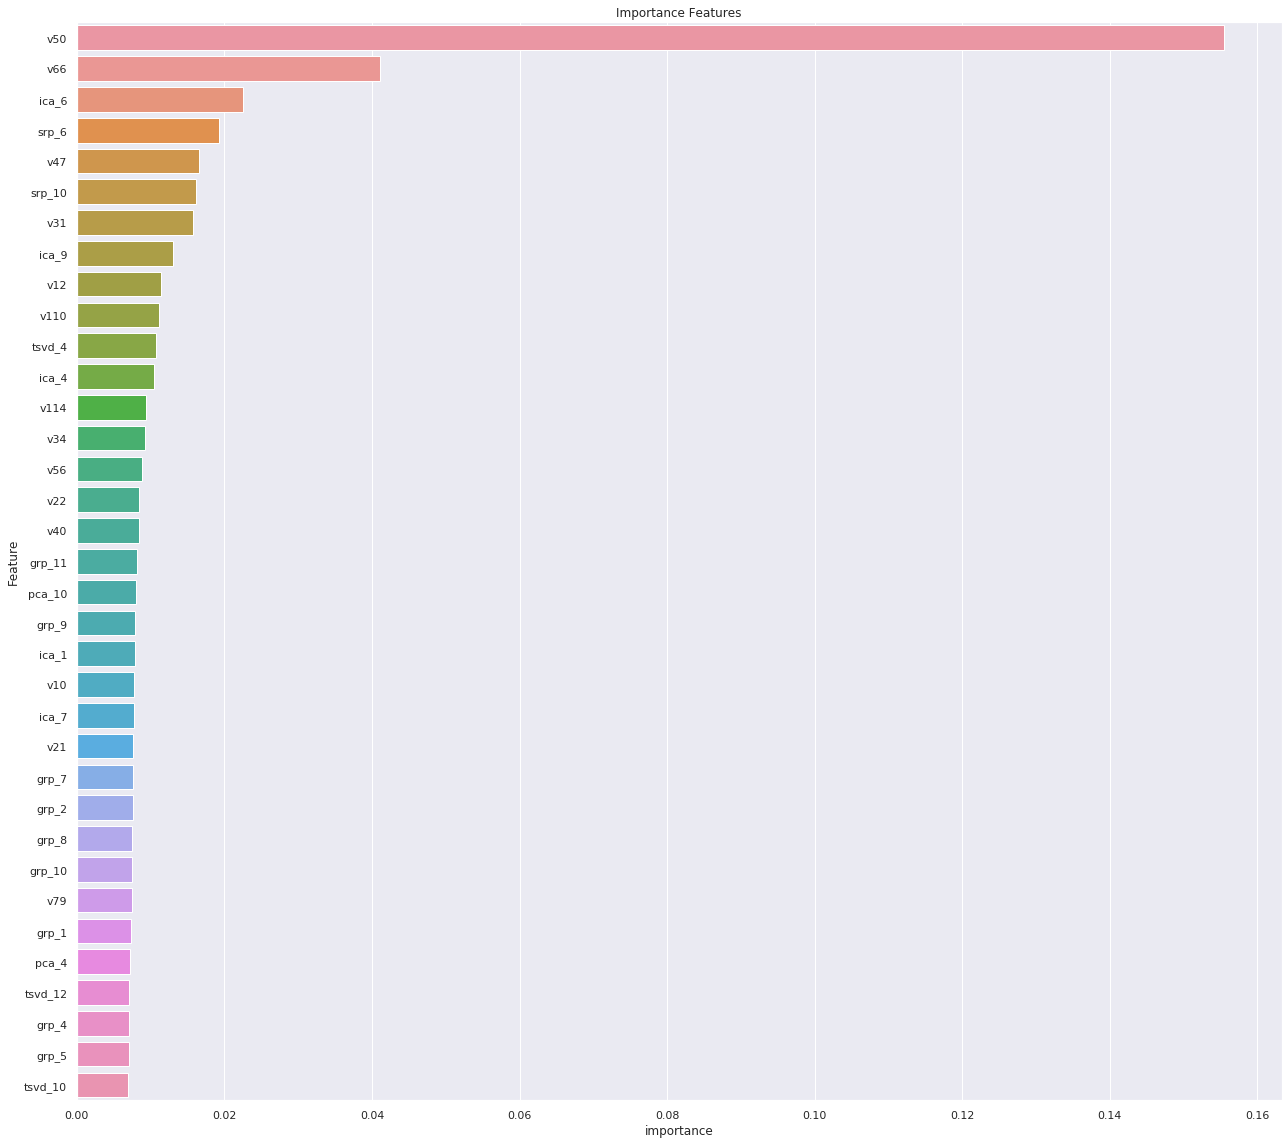

In [19]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:35].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,16))
sns.barplot(x="importance",
           y="Feature",
           data=best_features.sort_values(by="importance",
                                          ascending=False))
plt.title('Importance Features')
plt.tight_layout()

# Separando os datasets

In [20]:
# Split dos dados treino e test
X_treino = treino.loc[:,best_features['Feature']]
X_teste = teste.loc[:,best_features['Feature']]

y_treino = treino['target']

X_train, X_val, y_train, y_val = train_test_split(X_treino, y_treino, test_size=0.1, random_state=42)

# Logistic Regression

In [21]:
%%time

# Criação do Modelo
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

# Verificar performance nos dados de validaçaão
y_pred = lr.predict_proba(X_val)[:,1]
print("Log Loss (Val): %f" % log_loss(y_val, y_pred))

# Armazenar no dataset de treino e teste
treino['lr_prob'] = lr.predict_proba(X_treino).T[1]
teste['lr_prob'] = lr.predict_proba(X_teste).T[1]

Log Loss (Val): 0.487550
CPU times: user 5.69 s, sys: 132 ms, total: 5.82 s
Wall time: 992 ms


# Random Forest

In [22]:
%%time

# Criação do Modelo
rf = RandomForestClassifier(n_estimators=1500, random_state=1)
rf.fit(X_train, y_train)

# Verificar performance nos dados de validaçaão
y_pred = rf.predict_proba(X_val)[:,1]
print("Log Loss (Val): %f" % log_loss(y_val, y_pred))

# Armazenar no dataset de treino e teste
treino['rf_prob'] = rf.predict_proba(X_treino).T[1]
teste['rf_prob'] = rf.predict_proba(X_teste).T[1]

Log Loss (Val): 0.468514
CPU times: user 12min 42s, sys: 700 ms, total: 12min 43s
Wall time: 12min 42s


In [23]:
# in our case, 'isotonic' works better than default 'sigmoid'
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
calibrated_rf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=None,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                               

In [25]:
y_pred = calibrated_rf.predict_proba(X_val)
print("%.5f" % log_loss(y_val, y_pred, eps=1e-15, normalize=True))

0.47


# XGBoost Binary

In [28]:
%%time

bst = xgb.XGBClassifier(learning_rate = 0.01, 
                         n_estimators = 1000, 
                         max_depth = 4,
                         min_child_weight = 1, 
                         gamma = 0, 
                         subsample = 0.7, 
                         colsample_bytree = 0.6,
                         reg_alpha = 0.005,
                         objective = 'binary:logistic', 
                         n_jobs = -1,
                         scale_pos_weight = 1, 
                         seed = 0)

bst.fit(X_train, y_train)

CPU times: user 13min 45s, sys: 51.2 s, total: 14min 36s
Wall time: 2min 26s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.7, verbosity=1)

In [29]:
# Verificar performance nos dados de validaçaão
y_pred = bst.predict_proba(X_val).T[1]
print("Log Loss (Val): %f" % log_loss(y_val, y_pred))

# Armazenar no dataset de treino e teste
treino['xgb_prob'] = bst.predict_proba(X_treino).T[1]
teste['xgb_prob'] = bst.predict_proba(X_teste).T[1]

Log Loss (Val): 0.465147


In [30]:
# in our case, 'isotonic' works better than default 'sigmoid'
calibrated_bst = CalibratedClassifierCV(bst, method='isotonic', cv=5)

In [31]:
calibrated_bst.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.6,
                                                    gamma=0, learning_rate=0.01,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=1000,
                                                    n_jobs=-1, nthread=None,
                                                    objective='binary:logistic',
                                                    random_s

In [32]:
y_pred = calibrated_bst.predict_proba(X_val)
print("%.5f" % log_loss(y_val, y_pred, eps=1e-15, normalize=True))

0.46348


In [33]:
# Armazenar no dataset de treino e teste
treino['xgb_prob'] = calibrated_bst.predict_proba(X_treino).T[1]
teste['xgb_prob'] = calibrated_bst.predict_proba(X_teste).T[1]

# XGBoost Multisoft

In [39]:
%%time

bstm = xgb.XGBClassifier(learning_rate = 0.01, 
                         n_estimators = 1000, 
                         max_depth = 4,
                         min_child_weight = 1, 
                         gamma = 0, 
                         subsample = 0.7, 
                         colsample_bytree = 0.6,
                         reg_alpha = 0.005,
                         objective = 'multi:softprob', 
                         num_class = 2,
                         n_jobs = -1,
                         scale_pos_weight = 1, 
                         seed = 0)

bstm.fit(X_train, y_train)

CPU times: user 10min 59s, sys: 7.34 s, total: 11min 6s
Wall time: 55.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, num_class=2, objective='multi:softprob',
              random_state=0, reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.7, verbosity=1)

In [40]:
# Verificar performance nos dados de validaçaão
y_pred = bstm.predict_proba(X_val).T[1]
print("Log Loss (Val): %f" % log_loss(y_val, y_pred))

# Armazenar no dataset de treino e teste
treino['xgm_prob'] = bstm.predict_proba(X_treino).T[1]
teste['xgm_prob'] = bstm.predict_proba(X_teste).T[1]

Log Loss (Val): 0.465472


In [41]:
# in our case, 'isotonic' works better than default 'sigmoid'
calibrated_bstm = CalibratedClassifierCV(bstm, method='isotonic', cv=5)

In [42]:
calibrated_bstm.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.6,
                                                    gamma=0, learning_rate=0.01,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=1000,
                                                    n_jobs=-1, nthread=None,
                                                    num_class=2,
                                                    objective='multi:softpro

In [43]:
y_pred = calibrated_bstm.predict_proba(X_val)
print("%.5f" % log_loss(y_val, y_pred, eps=1e-15, normalize=True))

0.46347


In [44]:
# Armazenar no dataset de treino e teste
treino['xgm_prob'] = calibrated_bstm.predict_proba(X_treino).T[1]
teste['xgm_prob'] = calibrated_bstm.predict_proba(X_teste).T[1]

In [45]:
# Save submission (test data) and feature importance
treino.to_csv('../dataset/treino_com_prev.csv', index=False)
teste.to_csv('../dataset/teste_com_prev.csv', index=False)

# Stacking todos os modelos

In [46]:
treino.head()

,ID,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119_x,v12,v120,v121,v122,v123_x,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48_x,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62_x,v63,v64,v65,v66,v67,v68,v69,...,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12,v62_y,v119_y,v123_y,v48_y,v85_y,v62^2,v62 v119,v62 v123,v62 v48,v62 v85,v119^2,v119 v123,v119 v48,v119 v85,v123^2,v123 v48,v123 v85,v48^2,v48 v85,v85^2,v62^3,v62^2 v119,v62^2 v123,v62^2 v48,v62^2 v85,v62 v119^2,v62 v119 v123,v62 v119 v48,v62 v119 v85,v62 v123^2,v62 v123 v48,v62 v123 v85,v62 v48^2,v62 v48 v85,v62 v85^2,v119^3,v119^2 v123,v119^2 v48,v119^2 v85,v119 v123^2,v119 v123 v48,v119 v123 v85,v119 v48^2,v119 v48 v85,v119 v85^2,v123^3,v123^2 v48,v123^2 v85,v123 v48^2,v123 v48 v85,v123 v85^2,v48^3,v48^2 v85,v48 v85^2,v85^3,lr_prob,rf_prob,xgb_prob,xgm_prob
0,3,1.0,-0.272688,-0.988228,1.071308,0.650933,-0.074123,-0.750536,-1.204303,-0.479126,0.270231,1.182075,0.254955,-0.066452,1.252606,0.831485,-1.969710,0.883153,0.844842,0.787983,-4.050426,-0.506524,-0.470995,-1.222867,-0.747690,-0.860540,-0.316803,-1.425299,0.656397,-0.600569,-0.421304,-0.971775,0.261331,-0.076986,-0.004848,-0.447656,-0.792381,-1.019741,0.986146,-0.318835,-0.991890,2.040279,-0.081798,-1.144070,-0.451169,0.432629,0.947942,0.653599,1.407234,-0.273492,-0.947545,-0.528972,-0.278892,0.785220,-1.677191,0.523683,-0.134466,-1.310776,-0.468331,-0.954659,-1.168345,0.426462,0.189850,-0.865791,-0.535955,-0.15536,1.163668,-0.193398,-0.868666,0.467604,-0.221216,-0.309053,-0.138143,0.344093,-0.525524,-0.926604,-0.169861,0.075643,-0.404085,-0.519778,0.031078,0.127292,1.299683,-0.527208,-0.313184,0.564731,-0.157510,-1.048515,0.148549,0.274879,-0.231802,0.603384,-0.044084,-0.518305,0.011002,1.306966,1.676532,0.022367,-1.006445,4.049148,...,1.826808,0.384082,-1.925611e-03,0.394732,-1.309291,-2.383022,0.706463,0.001507,0.613460,-1.423669,1.121539,-1.177009,0.000360,-1.215617,2.104040,0.319406,-0.330315,0.001974,-0.349595,2.646866,-2.272656,0.995237,0.001351,0.919744,-2.196292,-0.002955,0.508014,0.000863,-0.417986,3.865399,-5.492231,0.465660,-0.000453,0.377347,3.076456,1.289634,-2.045385,0.000979,-1.793002,-5.326863,3.765487,-0.044084,-0.747690,-0.600569,-0.169861,-0.783912,0.001943,0.032961,0.026475,0.007488,0.034558,0.559040,0.449040,0.127004,0.586123,0.360683,0.102014,0.470794,0.028853,0.133156,0.614518,-0.000086,-0.001453,-0.001167,-0.000330,-0.001523,-0.024644,-0.019795,-0.005599,-0.025838,-0.015900,-0.004497,-0.020754,-0.001272,-0.005870,-0.027090,-0.417989,-0.335742,-0.094959,-0.438239,-0.269679,-0.076275,-0.352008,-0.021573,-0.099560,-0.459469,-0.216615,-0.061266,-0.282744,-0.017328,-0.079970,-0.369061,-0.004901,-0.022618,-0.104383,-0.481729,0.804876,0.888667,0.822301,0.831177
1,4,1.0,-0.152739,-0.408217,0.343954,-0.102485,-0.235151,-0.140532,-0.150268,0.186929,0.102292,-0.944226,-0.356590,0.018854,0.058962,-0.980198,-0.175037,1.895383,-0.837254,-1.248627,-0.035365,-0.099858,0.634481,-0.112593,-0.403692,-0.403661,-0.200081,-0.222618,-0.040170,-0.313198,-0.155797,-1.562332,-0.116022,-0.167562,-0.066830,-0.447656,-0.175687,-0.290378,-0.132612,-0.318835,-0.124409,0.005355,-0.142857,-0.103772,-0.145650,-0.151665,0.228873,-0.254272,-0.285476,-0.273492,-0.947545,0.458340,-0.091518,-0.081771,-0.019800,0.071444,-0.134466,-1.310776,-0.468331,-0.118370,-0.221288,-1.376429,-0.040449,0.514313,-0.185341,-0.15536,-0.364871,0.053680,1.210403,0.021788,0.008272,-0.099063,-0.006124,0.006590,0.281461,-0.215868,-0.059996,0.007975,0.220285,-0.108701,-0.026100,0.127292,0.074515,-0.054427,-0.22

In [49]:
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.pipeline import make_pipeline, make_union
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import check_array

class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [50]:
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, 
                                                          loss="huber", 
                                                          max_depth=4, 
                                                          max_features=0.55, 
                                                          min_samples_leaf=17, 
                                                          min_samples_split=14, 
                                                          subsample=0.7)),
    LassoLarsCV()

)

In [51]:
features = ['lr_prob','rf_prob','xgb_prob','xgm_prob'] 
stacked_pipeline.fit(treino[features], y_treino)

Pipeline(memory=None,
         steps=[('stackingestimator-1',
                 StackingEstimator(estimator=LassoLarsCV(copy_X=True, cv=None,
                                                         eps=2.220446049250313e-16,
                                                         fit_intercept=True,
                                                         max_iter=500,
                                                         max_n_alphas=1000,
                                                         n_jobs=None,
                                                         normalize=True,
                                                         positive=False,
                                                         precompute='auto',
                                                         verbose=False))),
                ('stackingestimator-2',
                 StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.9...
                                                            

In [54]:
treino['stk_prob'] = stacked_pipeline.predict(treino[features])
teste['stk_prob'] = stacked_pipeline.predict(teste[features])

In [56]:
print("Log Loss (Modelo A): %f" % log_loss(y_treino, treino['lr_prob']))
print("Log Loss (Modelo B): %f" % log_loss(y_treino, treino['rf_prob']))
print("Log Loss (Modelo C): %f" % log_loss(y_treino, treino['xgb_prob']))
print("Log Loss (Modelo D): %f" % log_loss(y_treino, treino['xgm_prob']))
print("Log Loss (Modelo E): %f" % log_loss(y_treino, treino['stk_prob']))

Log Loss (Modelo A): 0.494446
Log Loss (Modelo B): 0.163730
Log Loss (Modelo C): 0.462977
Log Loss (Modelo D): 0.462664
Log Loss (Modelo E): 0.050707


# Submissions

In [58]:
teste.head()

,ID,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119_x,v12,v120,v121,v122,v123_x,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48_x,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62_x,v63,v64,v65,v66,v67,v68,v69,...,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12,v62_y,v119_y,v123_y,v48_y,v85_y,v62^2,v62 v119,v62 v123,v62 v48,v62 v85,v119^2,v119 v123,v119 v48,v119 v85,v123^2,v123 v48,v123 v85,v48^2,v48 v85,v85^2,v62^3,v62^2 v119,v62^2 v123,v62^2 v48,v62^2 v85,v62 v119^2,v62 v119 v123,v62 v119 v48,v62 v119 v85,v62 v123^2,v62 v123 v48,v62 v123 v85,v62 v48^2,v62 v48 v85,v62 v85^2,v119^3,v119^2 v123,v119^2 v48,v119^2 v85,v119 v123^2,v119 v123 v48,v119 v123 v85,v119 v48^2,v119 v48 v85,v119 v85^2,v123^3,v123^2 v48,v123^2 v85,v123 v48^2,v123 v48 v85,v123 v85^2,v48^3,v48^2 v85,v48 v85^2,v85^3,lr_prob,rf_prob,xgb_prob,xgm_prob,stk_prob
114321,0,NaN,-0.235831,-0.408216,1.105812,-1.138088,-0.557209,-0.949239,-1.060594,-0.480353,-0.031859,-0.944226,-0.710879,-0.553415,1.782764,-0.980198,0.134243,1.895383,0.844842,-0.507425,0.464054,-1.513677,-0.971940,-1.260584,-0.747690,0.087425,0.224982,0.387371,0.443976,-0.667606,-0.438161,-1.562332,-0.755340,0.409342,-0.506928,-0.447656,-0.588922,0.318883,-0.272456,0.092554,-0.421793,-1.152055,-0.174128,-1.159416,0.018074,1.324716,0.119099,0.378636,-1.169020,-0.273492,0.844250,-0.552745,-1.660110,1.980244,-1.683554,-0.946520,-0.134466,0.831418,-0.468331,-0.897756,-0.083196,-0.580595,0.042868,-0.502347,0.172623,-0.155360,0.671848,0.050142,0.406059,-0.415845,-2.078041,-1.420440,-0.083573,0.134855,-0.530042,1.560973,0.104913,-0.563754,-1.058922,-1.188562,0.553405,-1.034200,1.642083,-0.524085,-0.266913,-1.703937,-2.179824,-1.083261,-0.745073,-0.597086,-1.654594,0.156728,-0.044084,-0.539202,-0.145643,-0.123574,-0.735050,-1.120618,-0.711464,-0.462480,...,-4.342101,-0.004153,-4.441748,-1.625384,-3.323900,-0.599351,0.001862,-0.670642,1.571494,-0.945841,-3.226981,-0.002076,-3.043604,-3.210511,4.944056,1.886218,0.000007,1.882102,-2.482832,-0.902291,-0.309845,-0.000756,-0.235682,-4.358365,2.558042,0.646489,0.001525,-1.141162,-2.236179,-2.643698,-2.325760,0.003702,-1.585627,-3.445827,1.943519,-1.227811,-0.000605,-1.428277,2.430616,-0.661387,-0.044084,-0.747690,-0.667606,0.104913,-0.675927,0.001943,0.032961,0.029430,-0.004625,0.029797,0.559041,0.499162,-0.078442,0.505384,0.445698,-0.070040,0.451253,0.011007,-0.070913,0.456877,-0.000086,-0.001453,-0.001297,0.000204,-0.001314,-0.024644,-0.022005,0.003458,-0.022279,-0.019648,0.003088,-0.019893,-0.000485,0.003126,-0.020141,-0.417989,-0.373219,0.058650,-0.377871,-0.333244,0.052368,-0.337397,-0.008230,0.053021,-0.341602,-0.297550,0.046759,-0.301259,-0.007348,0.047342,-0.305014,0.001155,-0.007440,0.047932,-0.308815,0.518990,0.365333,0.257900,0.288806,0.244035
114322,1,NaN,-0.152739,-0.423892,0.343954,-0.102485,-0.235151,-0.140532,-0.150268,-0.374918,0.102292,0.473308,-0.187775,-0.296653,0.058962,0.831485,-0.175037,-0.803898,0.844842,1.036508,-0.035365,-0.099858,-0.069002,-0.112593,-0.403692,-0.283855,-0.200081,-0.222618,-0.040170,-0.313198,-0.372219,1.036116,-0.116022,-0.167562,-0.215477,-0.447656,-0.175687,-0.290378,-0.132612,-0.925501,-0.124409,0.005355,-0.142857,-0.103772,-0.145650,-0.151665,0.228873,-1.068434,-0.415084,-0.273492,-0.051647,-0.419802,-0.091518,-0.081771,-0.019800,0.071444,-0.134466,-2.167654,-0.468331,-0.118370,-0.221288,0.977572,-0.040449,0.163967,-0.185341,6.790128,-0.364871,0.053680,-1.175713,0.021788,0.008272,-0.099063,-0.006124,0.006590,-0.414751,-0.926604,-0.059996,0.007975,-0.039406,-0.410410,-0.026100,-1.614946,0

In [59]:
# Save submission (test data) and feature importance
teste[['ID', 'xgm_prob']].to_csv('../submission/submission_stacking_v.1.0.3.csv', index=False)

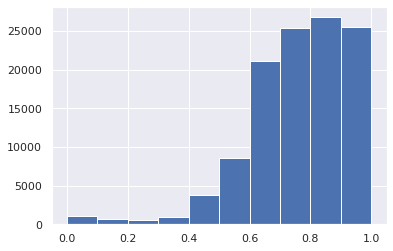

In [60]:
plt.hist(teste.xgm_prob)
plt.show()